# Small demo of what we have so far

In [1]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Generate 200 i.i.d examples

In [2]:
N = 500
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
Y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

Predictions can become informative at step $\lceil 2/\epsilon \rceil$, so for the first steps, ConformalRidgeRegressor will issue a warning if we try to predict anything before the training set is sufficiently large, and the prediction set will be infinite. However, we may as well learn the first few examples in one go, using .learn_inital_training_set

In [3]:
from online_cp import ConformalRidgeRegressor

cp = ConformalRidgeRegressor(rnd_state=2024)

epsilon = 0.1

cp.learn_initial_training_set(X[:int(np.ceil(2/epsilon))], Y[:int(np.ceil(2/epsilon))])

In [4]:
# Current training set
print(cp.X)
print()
print(cp.y)

[[ 1.02885687  1.64192004  1.14671953 -0.97317952]
 [-1.3928001   0.06719636  0.86135092  0.5091868 ]
 [ 1.81028557  0.75084347  0.63975955 -0.73132252]
 [-1.10771704  1.48440559  0.0489124   0.81152012]
 [-1.37642284 -0.43637074 -1.29109163 -0.77567868]
 [ 0.90306308 -1.48058133 -0.53409283  0.16378857]
 [-0.6684703  -0.25228976 -0.22186154  0.41813857]
 [-0.43125455  0.27226068  0.0568192   0.42456926]
 [ 0.22494339  1.65768406 -0.66367607  1.19918717]
 [-0.40261243 -0.95792617  1.21119447 -0.4395059 ]
 [-0.38763587 -1.38868368 -2.09819679  0.63430094]
 [-1.16526638  0.77827299  1.8481673  -0.11479795]
 [-1.1266151   0.39419917  0.76172847 -0.26179038]
 [ 0.01746449  1.33527073  1.26545198  0.70997823]
 [-0.86640088 -0.05367557  0.60291732 -0.21186587]
 [-0.61001793 -0.76538872 -0.63200882 -0.67160479]
 [-0.45111139  1.14567723 -0.80064198  0.88690207]
 [ 0.41758466  0.13974968 -0.82740186 -0.45669421]
 [ 1.97355534  0.09906791  0.53820775  0.66303163]
 [ 1.05564154 -0.23751636 -0.61

Predictions are tuples with lower and upper bounds of the intervals.

In [5]:
Gamma = cp.predict(X[20], epsilon=epsilon)

print(f'Prediction set: {Gamma}')

print(f'Label: {Y[20]}')
print(f'err: {cp.err(Gamma, Y[20])}')

Prediction set: (-2.06826591849286, 2.558252703354937)
Label: 0.22586021779209403
err: 0


Or if we want just upper or lower bounds, this can also be done

In [6]:
Gamma = cp.predict(X[20], epsilon=epsilon, bounds='upper')

print(f'Prediction set: {Gamma}')

print(f'Label: {Y[20]}')
print(f'err: {cp.err(Gamma, Y[20])}')

Prediction set: (-inf, 1.6056651654697836)
Label: 0.22586021779209403
err: 0


We can also compute the smoothed p-value of the object (but internally, for prediction, non-smoothed p-values are used), which can be used to test echangeablility using a test martingale.

In [7]:
cp.compute_smoothed_p_value(X[20], Y[20])

0.31789673038006105

Next, we learn the new object

In [8]:
cp.learn_one(X[20], Y[20])

# The full prediction Procedure
Because predict, learn, and compute smoothed p-value have some computations in common, predict can return a "precomputed" object, that can be passed to the others to speed up calculations. 

When a new object is added, rather than recomputing from scratch, we use the Sherman Morrison formula to update online, which is a lot faster than adding a row and inverting the "hat" matrix.

While we go along, the smoothed p-values can be used as an exchangeability check. We can set a warning level and rely on Ville's theorem. If ever the martingale grows beyond the warning level, the exchangeability hypothesis can be rejected at the corresponding confidence level.

Running online conformal prediction:   0%|          | 0/480 [00:00<?, ?it/s]

Error rate: 0.06666666666666667
Maximum martingale value: 1.4889950071130456


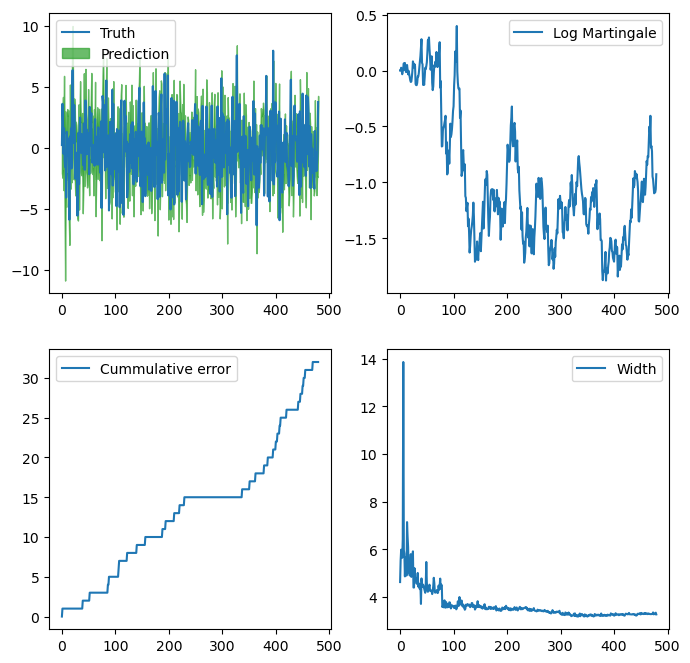

In [9]:
from online_cp.martingale import PluginMartingale

cp = ConformalRidgeRegressor()
martingale = PluginMartingale(warning_level=100)

epsilon = 0.1

Err = 0 

cp.learn_initial_training_set(X[:int(np.ceil(2/epsilon))], Y[:int(np.ceil(2/epsilon))])

res = np.zeros(shape=(N-20, 7))

for i, (object, label) in tqdm(enumerate(zip(X[int(np.ceil(2/epsilon)):], Y[int(np.ceil(2/epsilon)):])), total=N-20, desc='Running online conformal prediction'):
    # Reality outputs object
    x = object

    # Forecaster outputs a prediction set 
    Gamma, precomputed = cp.predict(x=x, epsilon=epsilon, bounds='both', return_update=True) # We return the precomputed update for later use

    # Reality outputs label
    y = label

    # Observe error
    err = cp.err(Gamma=Gamma, y=y)
    Err += err

    # Learn new object
    cp.learn_one(x=x, y=y, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Compute smoothed p-value
    p = cp.compute_smoothed_p_value(x=x, y=y, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_martingale_value(p)

    res[i, 0] = Gamma[0]
    res[i, 1] = Gamma[1]
    res[i, 2] = label
    res[i, 3] = err
    res[i, 4] = Err
    res[i, 5] = cp.width(Gamma) # Simple efficiency criterion for interval predictions
    res[i, 6] = martingale.logM

print(f'Error rate: {Err/(N-20)}')
print(f'Maximum martingale value: {martingale.max}')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs[0,0].plot(res[:, 2], label='Truth')
axs[0,0].fill_between(
    x=[i for i in range(N-20)],
    y1=res[:, 0],
    y2=res[:, 1],
    color='C2',
    alpha=0.7,
    label='Prediction'
)
axs[0,0].legend()

axs[0,1].plot(res[:,6], label='Log Martingale')
axs[0,1].legend()

axs[1,0].plot(res[:, 4], label='Cummulative error')
axs[1,0].legend()

axs[1,1].plot(res[:, 5], label='Width')
axs[1,1].legend()

# Let's test it again for non-exchangeable data
Now we introduce two change points, but keep the same objects. 

In [10]:
beta1 = np.array([2, 1, 0, 0])
beta2 = np.array([0, 0, 100, 20])

Y1 = X[:int(N/2)] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
Y2 = X[int(N/2):N] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
Y = np.concatenate([Y1, Y2]) # The test martingale should raise a warning shortly after n = 501.

It is somewhat irritating to have the martingale warn throughout (which will happen), so user warnings can be turned off by passing an argument in the construction

Running online conformal prediction:   0%|          | 0/480 [00:00<?, ?it/s]

Error rate: 0.2125
Maximum martingale value: 577612521.4158114


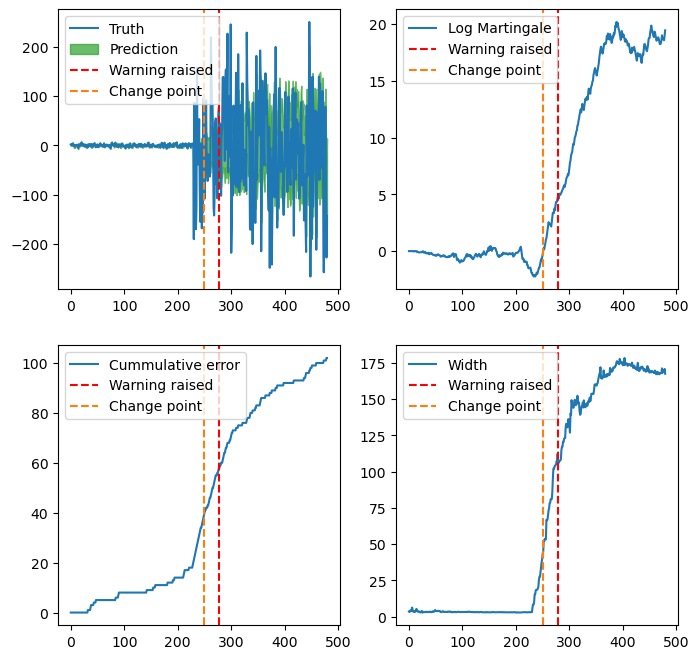

In [11]:
cp = ConformalRidgeRegressor(rnd_state=2024)
martingale = PluginMartingale(warning_level=100, warnings=False) # Disable user warnings because we check in the end

epsilon = 0.1

Err = 0 

cp.learn_initial_training_set(X[:int(np.ceil(2/epsilon))], Y[:int(np.ceil(2/epsilon))])

res = np.zeros(shape=(N-20, 7))

warned = False # Identify first step where warning is raised

for i, (object, label) in tqdm(enumerate(zip(X[int(np.ceil(2/epsilon)):], Y[int(np.ceil(2/epsilon)):])), total=N-20, desc='Running online conformal prediction'):
    # Reality outputs object
    x = object

    # Forecaster outputs a prediction set 
    Gamma, precomputed = cp.predict(x=x, epsilon=epsilon, bounds='both', return_update=True) # We return the precomputed update for later use

    # Reality outputs label
    y = label

    # Observe error
    err = cp.err(Gamma=Gamma, y=y)
    Err += err

    # Learn new object
    cp.learn_one(x=x, y=y, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Compute smoothed p-value
    p = cp.compute_smoothed_p_value(x=x, y=y, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_martingale_value(p)

    if martingale.max >= 100 and warned==False:
        warning_step = i # To identify the first time a warning was raised
        warned = True

    res[i, 0] = Gamma[0]
    res[i, 1] = Gamma[1]
    res[i, 2] = label
    res[i, 3] = err
    res[i, 4] = Err
    res[i, 5] = cp.width(Gamma)
    res[i, 6] = martingale.logM

print(f'Error rate: {Err/(N-20)}')
print(f'Maximum martingale value: {martingale.max}')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs[0,0].plot(res[:, 2], label='Truth')
axs[0,0].fill_between(
    x=[i for i in range(N-20)],
    y1=res[:, 0],
    y2=res[:, 1],
    color='C2',
    alpha=0.7,
    label='Prediction'
)
axs[0,0].axvline(warning_step, color='red', label='Warning raised', linestyle='dashed')
axs[0,0].axvline(int(N/2), color='C1', label='Change point', linestyle='dashed')
axs[0,0].legend()

axs[0,1].plot(res[:,6], label='Log Martingale')
axs[0,1].axvline(warning_step, color='red', label='Warning raised', linestyle='dashed')
axs[0,1].axvline(int(N/2), color='C1', label='Change point', linestyle='dashed')
axs[0,1].legend()

axs[1,0].plot(res[:, 4], label='Cummulative error')
axs[1,0].axvline(warning_step, color='red', label='Warning raised', linestyle='dashed')
axs[1,0].axvline(int(N/2), color='C1', label='Change point', linestyle='dashed')
axs[1,0].legend()

axs[1,1].plot(res[:, 5], label='Width')
axs[1,1].axvline(warning_step, color='red', label='Warning raised', linestyle='dashed')
axs[1,1].axvline(int(N/2), color='C1', label='Change point', linestyle='dashed')
axs[1,1].legend()

A warning was raised about 100 steps after the change point. Efficiency of conformal test martingales is an apen question, but the difficulty of detection depends on many things, including the nature of the change, and its magnitude. Plugin martingale approximates the optimal betting strategy, which is the likelihood ratio.

# We also have the nearest neighbours classifier

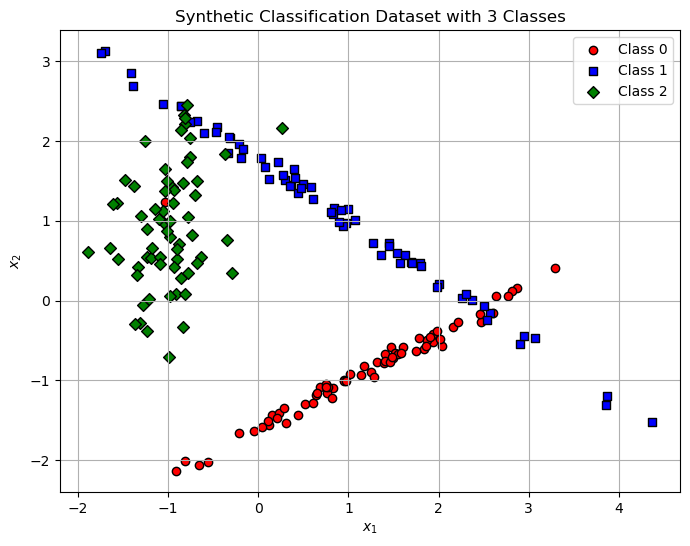

In [12]:
from sklearn.datasets import make_classification

N = 200

X, Y = make_classification(n_samples=N, n_features=2, n_informative=2, n_redundant=0, 
                           n_classes=3, n_clusters_per_class=1, random_state=2024)


# Create a scatter plot with different symbols for each class
plt.figure(figsize=(8, 6))

# Define different markers for each class
markers = ['o', 's', 'D']
colors = ['red', 'blue', 'green']

# Plot each class with a different marker
for label, marker, color in zip(np.unique(Y), markers, colors):
    plt.scatter(X[Y == label, 0], X[Y == label, 1], label=f'Class {label}', marker=marker, color=color, edgecolor='k')

# Add labels and a legend
plt.title('Synthetic Classification Dataset with 3 Classes')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.grid(True)
plt.show()

# Conformal nearest neighbours classifier
Nonconformity score for the one nearest neighbour classifier is the ratio 

$\frac{\text{Distance to nearest neighbour with the same label}}{\text{Distance to nearest neighbour with a different label}}$

In [13]:
from online_cp.classifiers import ConformalNearestNeighboursClassifier

cp = ConformalNearestNeighboursClassifier(k=1, label_space=np.unique(Y))

epsilon = 0.1

cp.learn_initial_training_set(X[:int(np.ceil(1/epsilon))], Y[:int(np.ceil(1/epsilon))])

In this case, prediction set is a list of possible labels. 

In [14]:
Gamma, p_values = cp.predict(X[10], epsilon=epsilon, return_p_values=True)

print(f'Prediction set: {Gamma}')
print(f'p-values: {p_values}')
print(f'Label: {Y[10]}')
print(f'err: {cp.err(Gamma, Y[10])}')

Prediction set: [0 2]
p-values: {0: 0.49201469662166697, 1: 0.03746924207621236, 2: 0.12837833298530327}
Label: 0
err: 0


# Run full example

Running online conformal prediction:   0%|          | 0/200 [00:00<?, ?it/s]

Average error: 0.125
Average observed excess: 0.135
Average observed fuzziness: 0.07740713184974359


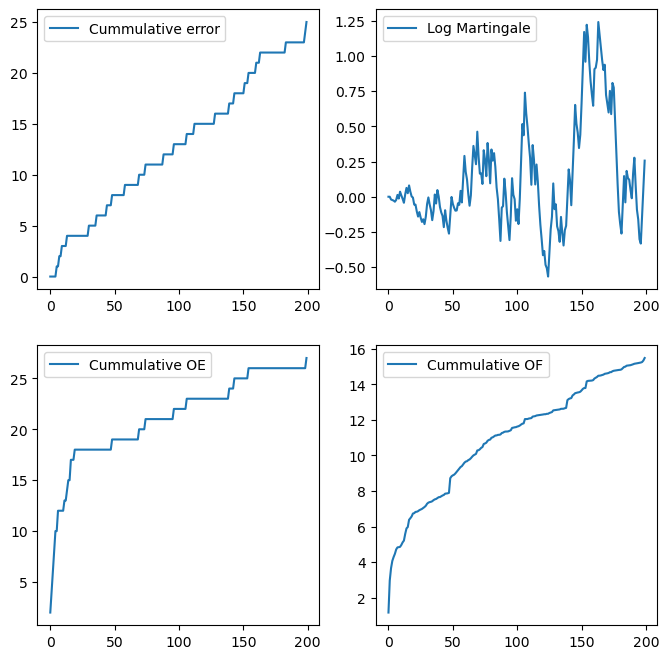

In [15]:
epsilon = 0.1
k = 1
cp = ConformalNearestNeighboursClassifier(k=k, label_space=np.unique(Y))

martingale = PluginMartingale(warning_level=100) # Disable user warnings because we check in the end

res = np.zeros(shape=(Y.shape[0], 4))

for i, (object, label) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0], desc='Running online conformal prediction'):

    # Reality outputs object
    x = object

    # Forecaster outputs prediction set
    Gamma, p_values, D = cp.predict(x, epsilon=epsilon, return_p_values=True, return_update=True)

    # Reality outputs label
    y = label

    # Check error
    cp.err(Gamma, label)

    # Learn the label
    cp.learn_one(object, y, D)
    
    # Prefferred efficiency criteria

    # Observed excess
    cp.oe(Gamma, y)

    # Observed fuzziness
    cp.of(p_values, y)

    # Update martingale
    martingale.update_martingale_value(p_values[y])


    res[i, 0] = cp.OE
    res[i, 1] = cp.OF
    res[i, 2] = cp.Err
    res[i, 3] = martingale.logM

print(f'Average error: {cp.Err/Y.shape[0]}')
print(f'Average observed excess: {cp.OE/Y.shape[0]}')
print(f'Average observed fuzziness: {cp.OF/Y.shape[0]}')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs[0,0].plot(res[:, 2], label='Cummulative error')
axs[0,0].legend()

axs[0,1].plot(res[:,3], label='Log Martingale')
axs[0,1].legend()

axs[1,0].plot(res[:, 0], label='Cummulative OE')
axs[1,0].legend()

axs[1,1].plot(res[:, 1], label='Cummulative OF')
axs[1,1].legend()

# Future considerations

There are some other conformal predictors implemented, including nearest neighbours and kernel ridge regression (with several kernels), as well as a (possibly correct) nearest neighbours conformal predictite system. 

### Release minimal version 
For use in projects, it may be good to have a released minimal version of OnlineConformalPrediction. Initially, it could include
* Conformalised Ridge Regression
* Plugin martingale
* Possibly Conformalised Nearest Neighbours Regression (but I will have to check it carefully for any bugs)
* Conformal Nearest Neighbours Classification

I don't know if such a minimal version should be acompanied by a paper, or if that can wait. Feels like a Copa paper for next year.

### Linear regression
We will initally focus on regression, but online classification is actually easier. A simple class that uses e.g. scikit-learn classifiers to define nonconformity measure could be easily implemented. 

There are at least three commonly used regularisations used in linear regression, all of which are compatible with the kernel trick. 
* $L1$ (Lasso)
* $L2$ (Ridge)
* Linear combination of the above (Elastic net)

All of these can be conformalized, and at least Ridge can also be used in conformal predictive systems (CPS).

There is also the Studentized for of ridge regression, and Bayesian ridge regression to consider.

Another relatively simple regressor is the k-nearest neighbours algorithm, which is very flexible as it can use arbitrary distances. It is particularly interesting in the CPS setting. The distance can be measured in feature space as defined by a kernel.

Ridge and KNN are described in detail in Algorithmic Learning in a Random World. Lasso and Elastic net are conformalised in the paper Fast Exact Conformalization of Lasso using Piecewise Linear Homotopy, but I am unaware of any extention to CPS. 

### Classification
* Support Vector Machines (SVM) can be conformalised, and should probably be included